# Assignment: Reinforcement Learning

### Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Imported Tic-Tac-Toe class from the environment file

In [1]:
from SS_TCGame_Env1 import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):
    env=TicTacToe()                                        ####- calling the environment as env
    valid_Actions = []   
    valid_Actions = [i for i in env.action_space(state)[0]] 
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy

In [5]:
# Defining epsilon-greedy policy

def epsilon_greedy(state, episode):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-rate_of_decay*episode)
    z = np.random.random()
    if z > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)  #Exploitation: this gets the action corresponding to max q-value of current state
        
    else:
        available_action = [i for i in env.action_space(state)[0]]        
        action = available_action[np.random.choice(range(len(available_action)))]    #Exploration: randomly choosing an action
        
    return action

#### Tracking the state-action pairs for checking convergence

In [6]:
# Initialising Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [7]:
# Initialising states to be tracked
def initialise_tracking_states():
    sample_q_values = [('x-x-x-x-x-x-x-x-x',(1,9)),('4-x-x-1-x-x-x-x-x',(4, 7)),('7-x-x-x-x-x-x-x-4',(3, 3)),('x-x-9-6-x-x-x-x-x',(1, 5))]
    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 200th episode         

In [8]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [10]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [11]:
EPISODES = 1000000

LR = 0.01                   #learning rate
GAMMA = 0.91                # Discount factor


max_epsilon = 1.0
min_epsilon = 0.001
rate_of_decay= 0.0001

threshold = 200       #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
policy_threshold = 300    #every these many episodes, the Q-dict will be updated

### Q-update loop

In [12]:
start_time = time.time()

for episode in range(EPISODES):

    env=TicTacToe()     #creating an instance of the class
    curr_state = env.state
    add_to_dict(curr_state)
    
    terminal_flag=False
    
    while terminal_flag==False:        
        curr_state_string = Q_state(curr_state)
        curr_action=epsilon_greedy(curr_state,episode)
        next_state,reward,terminal_flag=env.step(curr_state,curr_action)
        next_state_string = Q_state(next_state)
        add_to_dict(next_state)
        
        # Update rule based on the terminal flag
        if terminal_flag==False:
            max_next = max(Q_dict[next_state_string],key=Q_dict[next_state_string].get)   #this gets the action corresponding to max q-value of next state
            Q_dict[curr_state_string][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_string][max_next]))) - Q_dict[curr_state_string][curr_action])
                
        else:
            Q_dict[curr_state_string][curr_action] += LR * (reward - Q_dict[curr_state_string][curr_action])

        
        curr_state = next_state       #moving to the next state
            
     #states tracking   
    if ((episode+1) % threshold)==0:
        save_tracking_states()
        save_obj(States_track,'States_tracked')

    if ((episode+1) % policy_threshold) == 0:  #every 300th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')      
        
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

In [32]:
# Running the Q update loop for 1 Million episodes took approx 4.6 hrs

elapsed_time

16586.36052274704

#### Checking the Q-dictionary

In [13]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.2372844556062959,
              (0, 3): -1.2401481210441094,
              (0, 5): -1.2402656174763758,
              (0, 7): -1.2403955646955913,
              (0, 9): -1.2405042445155081,
              (1, 1): -1.2401509178813444,
              (1, 3): -1.240172851350649,
              (1, 5): -1.2402932158742197,
              (1, 7): -1.2405453383460896,
              (1, 9): -1.2401133236073134,
              (2, 1): -1.2403141849510657,
              (2, 3): -1.2402171834658777,
              (2, 5): -1.2401861141648236,
              (2, 7): -1.2402368555900065,
              (2, 9): -1.2399977558852044,
              (3, 1): -1.2402710277283626,
              (3, 3): -1.2406664886138565,
              (3, 5): -1.240410156630268,
              (3, 7): -1.240117276452734,
              (3, 9): -1.2403259545229648,
              (4, 1): -1.2403044025914,
              (4, 3): -1.240256955607731,
              (4, 5): 

#### Checking the states tracked for Q-values convergence
(non-evaluative)

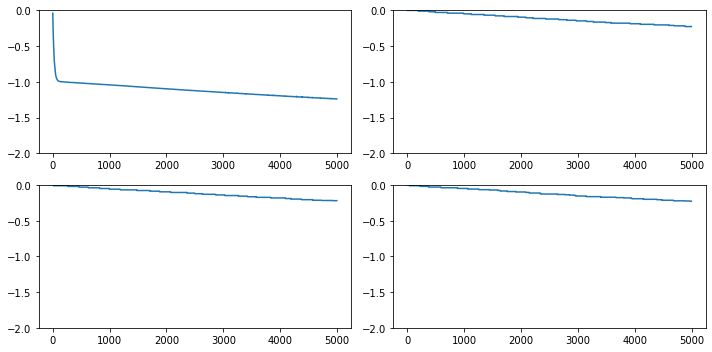

In [33]:
# Plotting the graphs for state-action pairs tracked

plt.figure(figsize = (10,5))

plt.subplot(2, 2, 1)
x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(1,9)])))
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(1,9)]))
plt.ylim((-2,0))
plt.tight_layout()

plt.subplot(2, 2, 2)
x_axis = np.asarray(range(0, len(States_track['4-x-x-1-x-x-x-x-x'][(4,7)])))
plt.plot(x_axis,np.asarray(States_track['4-x-x-1-x-x-x-x-x'][(4,7)]))
plt.ylim((-2,0))
plt.tight_layout()

plt.subplot(2, 2, 3)
x_axis = np.asarray(range(0, len(States_track['7-x-x-x-x-x-x-x-4'][(3,3)])))
plt.plot(x_axis,np.asarray(States_track['7-x-x-x-x-x-x-x-4'][(3,3)]))
plt.ylim((-2,0))
plt.tight_layout()

plt.subplot(2, 2, 4)
x_axis = np.asarray(range(0, len(States_track['x-x-9-6-x-x-x-x-x'][(1,5)])))
plt.plot(x_axis,np.asarray(States_track['x-x-9-6-x-x-x-x-x'][(1,5)]))
plt.ylim((-2,0))
plt.tight_layout()

As can be seen from the above graphs, the states converge as the number of episodes increase. The current results are for 1 Million episodes which took ~ 4.6 hrs to run. Upon running more episodes further convergence could be seen.

### Epsilon - decay check

In [21]:
time = np.arange(0,1000000)
epsilon = []
for i in range(0,1000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-rate_of_decay*i))

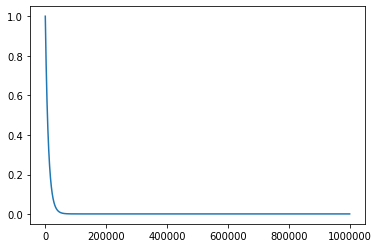

In [22]:
plt.plot(time, epsilon)
plt.show()